In [1]:
import os
from PIL import Image
from torch import Tensor
from seaborn import heatmap
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.colors as mcolors
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as Model
from torchvision import transforms
from prepare_data import ConvertRgb, Rescale, RandomPad, load_datasets, get_dataloaders, get_classes, get_sizes


MODEL_NAME = 'EffB7'
BATCH_SIZE = 64


NETS = {
    'EffB0': {'input_size': 224, 'model': Model.efficientnet_b0},
    'EffB1': {'input_size': 240, 'model': Model.efficientnet_b1},
    'EffB2': {'input_size': 288, 'model': Model.efficientnet_b2},
    'EffB3': {'input_size': 300, 'model': Model.efficientnet_b3},
    'EffB4': {'input_size': 380, 'model': Model.efficientnet_b4},
    'EffB5': {'input_size': 456, 'model': Model.efficientnet_b5},
    'EffB6': {'input_size': 528, 'model': Model.efficientnet_b6},
    'EffB7': {'input_size': 600, 'model': Model.efficientnet_b7},
    'Res18': {'input_size': 224, 'model': Model.resnet18},
    'Dense169': {'input_size': 224, 'model': Model.densenet169},
    'Dense201': {'input_size': 224, 'model': Model.densenet201}
    }

MODEL_TORCH = NETS[MODEL_NAME]['model']
INPUT_SIZE = NETS[MODEL_NAME]['input_size']

CLASSES = ['autre_epaule', 'autre_pistolet', 'epaule_a_levier_sous_garde',
        'epaule_a_percussion_silex', 'epaule_a_pompe', 'epaule_a_un_coup', 'epaule_a_verrou',
        'pistolet_a_percussion_silex', 'pistolet_semi_auto_moderne', 'revolver']

datasets = load_datasets(INPUT_SIZE)
classes = get_classes(datasets)
dataset_sizes = get_sizes(datasets)
dataloaders = get_dataloaders(datasets, batch_size=BATCH_SIZE)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

loader =  transforms.Compose([
            ConvertRgb(),
            Rescale(INPUT_SIZE),
            RandomPad(INPUT_SIZE),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])


def build_model(model: Model) -> Model:
    # freeze first layers
    for param in model.parameters():
        param.requires_grad = False
    # Parameters of newly constructed modules have requires_grad=True by default
    num_ftrs = model.classifier[1].in_features
    # to try later : add batch normalization and dropout
    model.classifier[1] = torch.nn.Linear(num_ftrs, len(CLASSES))
    model = model.to(device)
    return model


def load_model_inference(state_dict_path: str) -> Model:
    model = build_model(MODEL_TORCH())
    # Initialize model with the pretrained weights
    model.load_state_dict(torch.load(state_dict_path, map_location=device)['model_state_dict'])
    model.to(device)
    # set the model to inference mode
    model.eval()
    return model


In [2]:


model = load_model_inference('models/EffB7_2022-03-30_08/EffB7_2022-03-30_08.pth')

# Create data

In [4]:
df = pd.read_csv('models/EffB7_2022-03-30_08/probas_val.csv')
logits_list = torch.tensor(df[CLASSES].values)
print(logits_list)
labels_list = torch.tensor([CLASSES.index(x) for x in list(df['label'])])


print(logits_list.shape)
print(labels_list.shape)

tensor([[1.8359e-01, 2.0569e-03, 2.6507e-01,  ..., 1.0953e-03, 1.9875e-04,
         5.0387e-04],
        [5.9419e-01, 6.1531e-02, 1.8818e-03,  ..., 5.9179e-05, 1.8742e-04,
         3.9880e-05],
        [7.5271e-01, 6.1506e-03, 1.9812e-02,  ..., 3.5494e-03, 8.8224e-04,
         4.4460e-04],
        ...,
        [1.2004e-02, 8.7047e-01, 4.8886e-04,  ..., 2.9121e-02, 3.8888e-02,
         3.5887e-02],
        [2.1086e-09, 5.5580e-05, 1.1045e-08,  ..., 1.3203e-06, 3.2677e-05,
         9.9991e-01],
        [8.9345e-03, 8.3878e-02, 2.2073e-02,  ..., 2.0095e-01, 1.0281e-02,
         6.0956e-01]], dtype=torch.float64)
torch.Size([7067, 10])
torch.Size([7067])


# Temperature on data

## Custom implementation

In [5]:

def T_scaling(logits, temperature):
    return torch.div(logits, temperature)

class _ECELoss(nn.Module):
    """
    Calculates the Expected Calibration Error of a model.
    (This isn't necessary for temperature scaling, just a cool metric).
    The input to this loss is the logits of a model, NOT the softmax scores.
    This divides the confidence outputs into equally-sized interval bins.
    In each bin, we compute the confidence gap:
    bin_gap = | avg_confidence_in_bin - accuracy_in_bin |
    We then return a weighted average of the gaps, based on the number
    of samples in each bin
    See: Naeini, Mahdi Pakdaman, Gregory F. Cooper, and Milos Hauskrecht.
    "Obtaining Well Calibrated Probabilities Using Bayesian Binning." AAAI.
    2015.
    """
    def __init__(self, n_bins=10):
        """
        n_bins (int): number of confidence interval bins
        """
        super(_ECELoss, self).__init__()
        bin_boundaries = torch.linspace(0, 1, n_bins + 1)
        self.bin_lowers = bin_boundaries[:-1]
        self.bin_uppers = bin_boundaries[1:]

    def forward(self, logits, labels):
        confidences, predictions = torch.max(logits, 1)
        accuracies = predictions.eq(labels)

        ece = torch.zeros(1, device=logits.device)
        for bin_lower, bin_upper in zip(self.bin_lowers, self.bin_uppers):
            # Calculated |confidence - accuracy| in each bin
            in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
            prop_in_bin = in_bin.float().mean()
            if prop_in_bin.item() > 0:
                accuracy_in_bin = accuracies[in_bin].float().mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin

        return ece

In [6]:
temperature = nn.Parameter(torch.ones(1).to(device))
optimizer = optim.LBFGS([temperature], lr=0.0001, max_iter=800)

nll_criterion = nn.CrossEntropyLoss().to(device)
ece_criterion = _ECELoss().to(device)

before_temperature_nll = nll_criterion(logits_list, labels_list).item()
before_temperature_ece = ece_criterion(logits_list, labels_list).item()
print('Before temperature - NLL: %.3f, ECE: %.3f' % (before_temperature_nll, before_temperature_ece))

def _eval():
    loss = nll_criterion(T_scaling(logits_list, temperature), labels_list)
    loss.backward()
    return loss

optimizer.step(_eval)

after_temperature_nll = nll_criterion(T_scaling(logits_list, temperature), labels_list).item()
after_temperature_ece = ece_criterion(T_scaling(logits_list, temperature), labels_list).item()
print('Optimal temperature: %.3f' % temperature.item())
print('After temperature - NLL: %.3f, ECE: %.3f' % (after_temperature_nll, after_temperature_ece))

Before temperature - NLL: 1.745, ECE: 0.022
Optimal temperature: 0.160
After temperature - NLL: 0.707, ECE: 0.000


## With netcal library

In [7]:

confidences = logits_list.cpu().numpy()
ground_truth = labels_list.cpu().numpy()

In [8]:
from netcal.scaling import TemperatureScaling

temperature = TemperatureScaling()
temperature.fit(confidences, ground_truth)
calibrated = temperature.transform(confidences)

In [9]:
from netcal.metrics import ECE

n_bins = 10

ece = ECE(n_bins)
uncalibrated_score = ece.measure(confidences, ground_truth)
calibrated_score = ece.measure(calibrated, ground_truth)
print('uncalibrated_score', uncalibrated_score)
print('calibrated_score', calibrated_score)

uncalibrated_score 0.022205485171924146
calibrated_score 0.004607873072512219


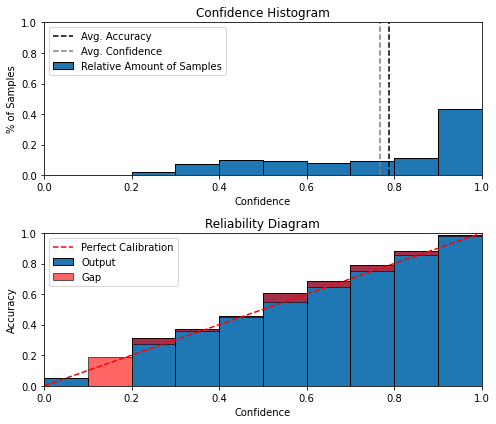

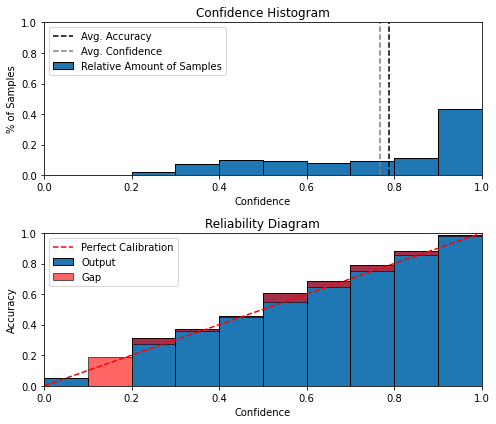

In [10]:
from netcal.presentation import ReliabilityDiagram

n_bins = 10

diagram = ReliabilityDiagram(n_bins)
diagram.plot(confidences, ground_truth)  # visualize miscalibration of uncalibrated


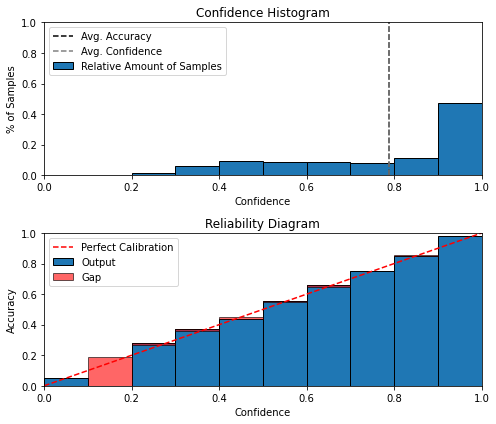

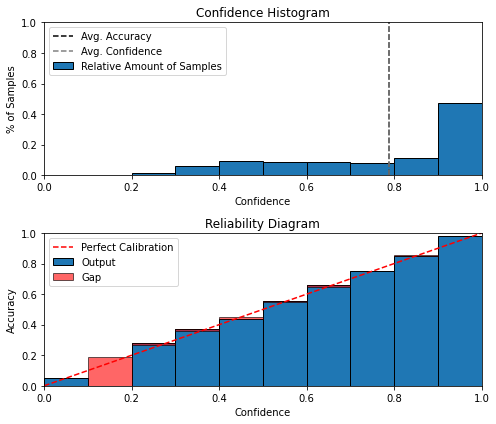

In [11]:
diagram.plot(calibrated, ground_truth)   # visualize miscalibration of calibrated